<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_Bagging_Pasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Bagging and Pasting on Moon Dataset

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply Bagging and Pasting ensamble learning to improve learning score

## Load Dataset

In [46]:
from sklearn.datasets import make_moons

from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import Image


In [2]:
# Create dataset
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Split dataset to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Default test size 25% of X

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (375, 2)
y_train shape: (375,)

X_test shape: (125, 2)
y_test shape: (125,)


## Bagging Classifier
Bagging classifier (aka. _bootstrpping_) use sampling with replacement. I need to set the `bootstrp=True` to specify that I want to use sampling with replacement. Unlike the __VotingClassifier__, it only train one type of estimator, but on multiple subsets of the training set.

In [6]:
bag_clf = BaggingClassifier(
    estimator = DecisionTreeClassifier(random_state=42),
    n_estimators=500, # Training 500 different DecisionTreeClassifiers
    max_samples=100, # number of samples to draw from X_train to train each base estimator (with replacement for bagging)
    bootstrap=True, # using Bagging instead of Pasting (sampling with replacement)
    n_jobs=-1, # using all available CPU cores
    oob_score=True, # compute out-of-bag score (for evaluation of the bagging classifier using the remaing 37% of unsampled data)
    random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

### Check Base Estimators
Here are the first two estimators.

In [37]:
bag_clf.estimators_[:2]

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086)]

Let's check the sample subsets used for trainig the first two estimators. Note that the length of each subset is 100 since I set `max_samples=100`.

In [39]:
# List of dynamically generated indices identifying samples used for fitting each member of ensamble
bag_clf.estimators_samples_[:2]

[array([ 41, 332, 130, 231,  92, 199, 370, 120,  28, 233,  84,   6, 324,
        338, 307, 105,  74, 290, 349, 260, 290,   8, 288,  59,  95,   3,
        150, 363, 302, 116, 194, 361,  77, 184, 336, 242, 241, 213,  64,
        256,  59, 103, 337,  41, 347,  70, 132, 256,  60, 279,  14, 234,
        249, 183, 203, 301, 340, 165, 100, 173, 213, 367,  23,  70,   1,
        337, 172, 294, 353, 367, 371,  52,   9, 338, 327, 109,  73, 372,
        217, 196,  14, 288, 104, 299, 104,  45, 357,  53, 261, 370, 146,
         36, 303, 279, 340, 240, 352,  39, 120, 292]),
 array([174, 151, 279,  31, 357, 234,   3, 303, 202,  83, 200, 163, 109,
        355, 104,  72, 274,  71, 249, 346, 117, 219,  51, 314,  75, 250,
         87, 184, 363,  16, 227, 341,  84, 227, 347,   7, 244, 193,  72,
          3, 131, 177, 317,  45,  31, 182, 226,  84, 171, 239, 258, 265,
        178, 313, 315, 119,  39, 184, 334,  53, 189, 139,  87, 193, 113,
         17, 297, 152, 119,  12, 121,  50, 339, 359, 225, 315,  55, 3

I used the following helper function to create a .got object and save .png image of the tree structure. The following cell plot the first two trees side-by-side.

In [45]:
def create_and_save_dot_image(tree_clf, size, filename):
    # Create and export .dot file
    export_graphviz(
            tree_clf,
            out_file= 'file.dot',
            # feature_names=iris.feature_names[2:],
            # class_names=iris.target_names,
            rounded=True,
            filled=True)

    # Read the .dot file into a string
    with open('file.dot', 'r') as file:
        dot_data = file.read()

    # Insert the size attribute into the string
    dot_data = dot_data.replace('digraph Tree {', f'digraph Tree {{\ngraph [size="{size}"];')

    # Create and save a Source object from the modified string
    src = Source(dot_data)
    src.render(filename, format='png')

    return f'{filename}.png'

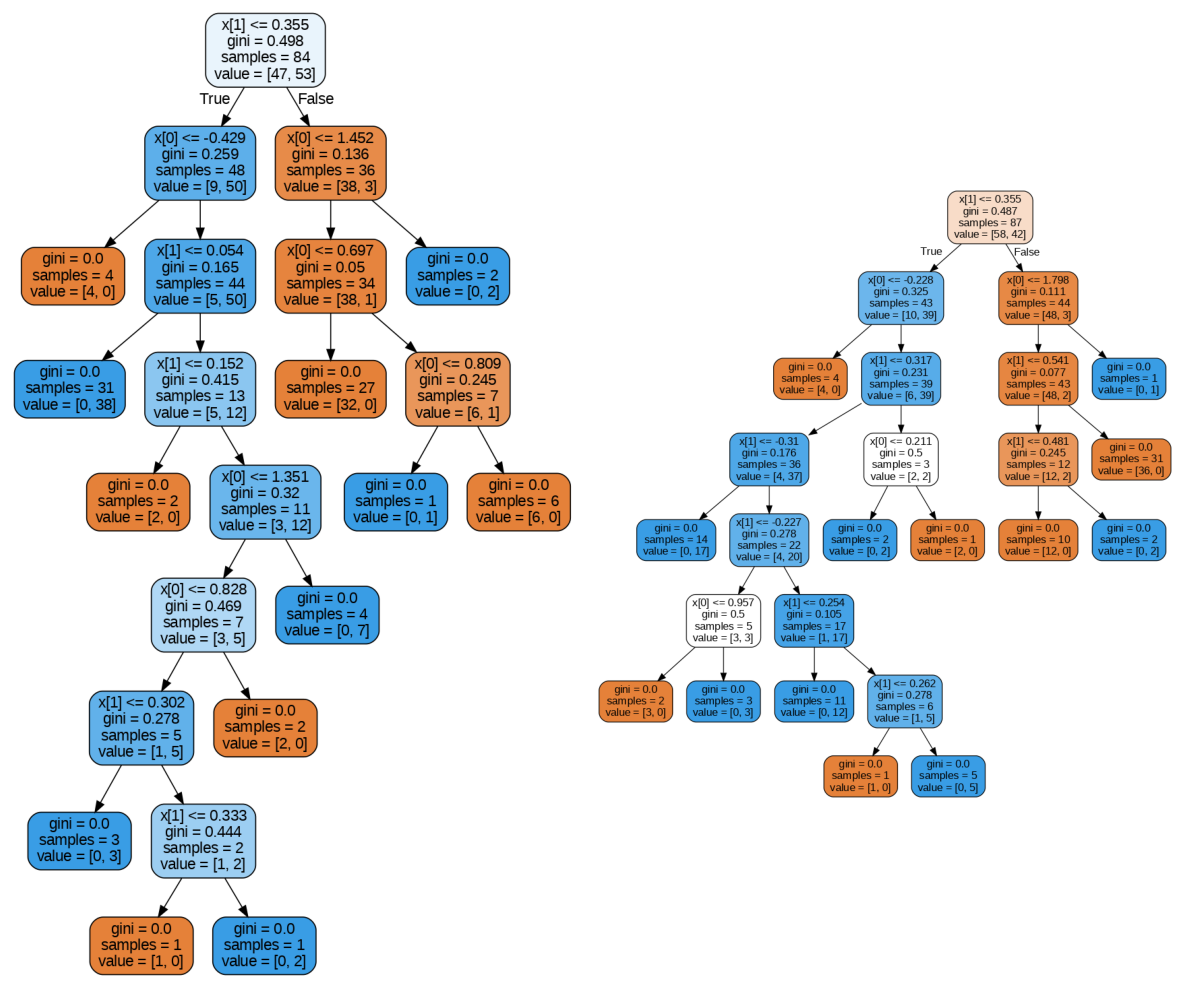

In [58]:
img_path1 = create_and_save_dot_image(bag_clf.estimators_[0], '15,15!', 'tree1')
img_path2 = create_and_save_dot_image(bag_clf.estimators_[1], '10,10!', 'tree2')

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

img1 = Image(filename=img_path1)
axes[0].imshow(plt.imread(img_path1))
axes[0].axis('off')

img2 = Image(filename=img_path2)
axes[1].imshow(plt.imread(img_path2))
axes[1].axis('off')

plt.tight_layout()
plt.show()

The tree structures are totally difference and this is because they use difference subsets for fitting. It is evident that how a single decision tree classifier is sensitive to the training instances.

Let's compare the the out-of-bag evaluation score with evaluation score of the model. The former is computed on the remaing 37% of the unsampled instances in the training set, and the latter is computed on the test set.

In [9]:
print(f"Out-of-bag score: {bag_clf.oob_score_:.3f}")
print(f"Test score: {bag_clf.score(X_test, y_test)}")

Out-of-bag score: 0.925
Test score: 0.904


In [36]:
# Another method to compute the score
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


It seems the OOB score is a bit optimistic.

In [10]:
bag_clf.oob_decision_function_[:3]

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ]])

In [32]:
X_train[:3]

array([[ 1.53869929,  0.18874413],
       [ 0.39469854,  0.32372361],
       [-0.91914656,  1.31188165]])

Note that because the base estimator (_DecisionTreeClassifier_) does not have `.decision_function` attribute, I can use that to get the average score of all 500 base estimators.

## Plot Desi